In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Reshape,Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import Input , Lambda
from keras import backend as k

# Loading the dataset:

In [2]:
import glob
data = glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/rock/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/scissors/*.png")
images = [plt.imread(img) for img in data]
print(len(images))

2520


In [3]:
# Map for quick lookup
label_map = {'paper': 0, 'rock': 1, 'scissors': 2}

# Efficient list comprehension
Y = np.array([label_map.get(x.split('/')[-2]) for x in data])

# Shuffle the arrays consistently
images = np.array(images)
images, Y = shuffle(images, Y, random_state=0)

# Display some images:

In [4]:
def display(images,a):
        m,n = 1, int(len(images)/a)
        for i in range(0,len(images),m*n):
            fig = plt.figure(figsize=(15,8))
            for j in range(m*n):
                fig.add_subplot(m,n,j+1)
                plt.imshow(images[i+j])
                plt.axis('off')
            plt.show()

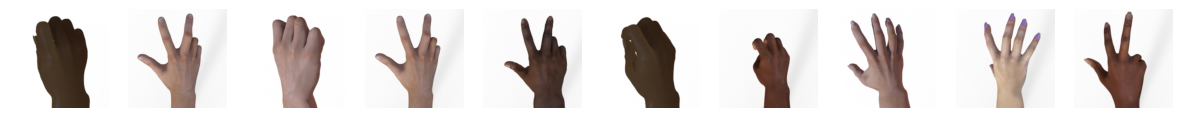

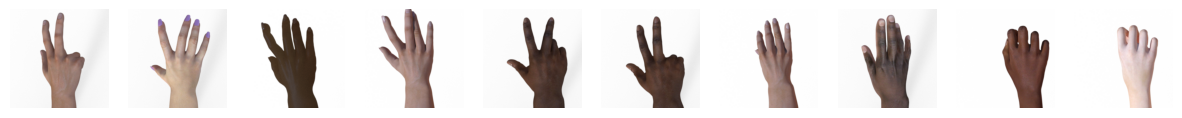

In [5]:
display(images[:20],2)

## Split the data into Train and Test:

In [7]:
XTrain,XTest ,YTrain,YTest =train_test_split(images, Y, train_size=0.8)
print(f'Train: {len(XTrain)} images. \n Test: {len(XTest)} images.')

Train: 2016 images. 
 Test: 504 images.


# Add noise to the images:

In [8]:
def noisy(I: np.array):
    mean = 0
    var = 0.2
    sigma = var ** 0.5
    
    # Generate Gaussian noise and add it directly to the input array
    gauss = np.random.normal(mean, sigma, I.shape)
    R = I + gauss

    # Apply the normalization function
    R = np.clip(R, 0, 1)  
    return R




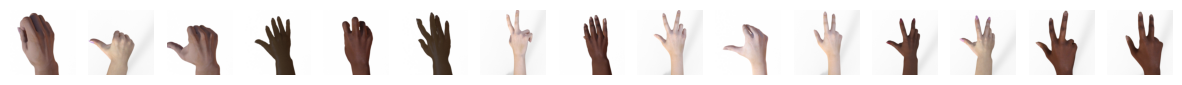

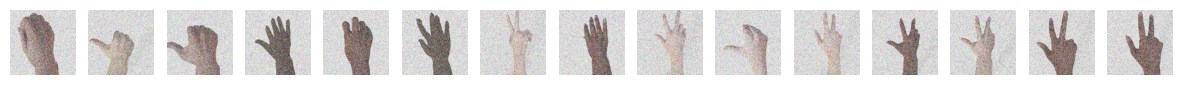

In [9]:
Ntrain = [noisy(img) for img in XTrain]
Ntrain = np.array(Ntrain)

# Dispaly some samples:
display(XTrain[:15],1)
display(Ntrain[:15],1)

# The Model:

In [10]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # Encoder:
        self.encoder = Sequential()
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu',input_shape=(300,300,4)))
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(32,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Flatten())
        self.encoder.add(Dense(100))#,activation = 'softmax'))
        # Decoder:
        self.decoder = Sequential()
        self.decoder.add(Dense(units = 34*34*8,activation = 'relu',input_shape=(100,)))
        self.decoder.add(Reshape(target_shape = (34, 34, 8)))
        self.decoder.add(UpSampling2D((2, 2),interpolation="bilinear"))
        self.decoder.add(BatchNormalization())
        self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(32,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        #self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(4,(3,3),1,activation = 'sigmoid'))

    def call(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode


In [11]:
denoising =  AutoEncoder()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
denoising.compile(optimizer =opt,loss = tf.losses.MeanSquaredError(),metrics = ['accuracy'])
denoising.build((1000,300,300,4))
denoising.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       939,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       948,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,887,264 (7.20 MB)

 Trainable params: 1,887,168 (7.20 MB)

 Non-trainable params: 96 (384.00 B)

## Train the model:

In [27]:
hist = denoising.fit(XTrain,XTrain,epochs = 100, validation_split=0.3)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.7909 - loss: 3.9611e-04 - val_accuracy: 0.8028 - val_loss: 7.3526e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7832 - loss: 3.8594e-04 - val_accuracy: 0.8029 - val_loss: 7.2677e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7930 - loss: 3.7955e-04 - val_accuracy: 0.8030 - val_loss: 7.3691e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7839 - loss: 3.9715e-04 - val_accuracy: 0.8027 - val_loss: 7.3865e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.7922 - loss: 3.9567e-04 - val_accuracy: 0.8029 - val_loss: 7.4604e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7895 - loss: 3.8560e-04 - val_accuracy: 0.8029 - val_loss: 7.3445e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7855 - loss: 3.9540e-04 - val_accuracy: 0.8029 - val_loss: 7.5775e-04
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6

# Evaluating the model:

In [28]:
Ntest = [noisy(img) for img in XTest]
Ntest = np.array(Ntest)
denoising.evaluate(Ntest,XTest)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7928 - loss: 0.0235


[0.023367376998066902, 0.80109703540802]

## Display some testing samples:

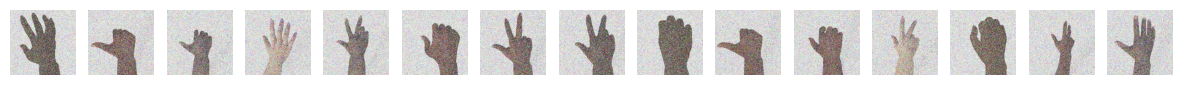

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


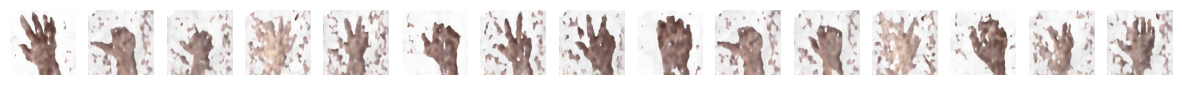

In [29]:
display(Ntest[10:25],1)
RN = denoising.predict(Ntest)
display(RN[10:25],1)